In [17]:
import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import pickle
from math import cos, pi

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from torchtext import data    
import spacy
import nltk
import itertools
import io
from imblearn.over_sampling import SMOTE
nlp = spacy.load('en')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device='cpu'
import read_preprocess
from models import DNN, dataset_csv
CUDA_LAUNCH_BLOCKING=1

from livelossplot import PlotLosses
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [18]:
class Discretize(BaseEstimator, TransformerMixin):
    def fit(self,X:pd.DataFrame):
        self.X = X
        self.X_num = self.X.select_dtypes(exclude=['category','uint8'])
        self.cols = self.X_num.columns.tolist()
        return self
    def transform(self,X):
        df_disc = pd.DataFrame()
        for col in self.cols:
            df_disc[col] = pd.cut(self.X_num[col],5,labels=['0_20','20_40','40_60','60_80','80_100'])
        df_disc = pd.get_dummies(df_disc,drop_first=False)
        
        return pd.concat([self.X,df_disc],axis=1)

In [19]:
frame = pd.read_csv('./adv_train.csv', index_col=False)
target = "Rating"
frame['Rating'].value_counts()

1    13317
2     4300
3     3256
4     1910
5     1337
Name: Rating, dtype: int64

In [20]:
def preprocess_sparse(frame_sparse):
    bad_na, good_na = [],[]
    for column in frame_sparse:
        if frame_sparse[column].isna().sum()/frame_sparse.shape[0] > 0.3:
            frame_sparse.append(column)
        elif frame_sparse[column].isna().sum()/frame_sparse.shape[0] <= 0.3 and frame_sparse[column].isna().any()==True:
            good_na.append(column)
        frame_sparse = frame_sparse.drop(bad_na,axis=1)
    print(f"Bad Frames: {len(bad_na)}")
    for col in good_na:
        frame_sparse[col] = frame_sparse[col].fillna(stats.stats.mode(frame_sparse[col])[0][0])
    return frame_sparse
frame = preprocess_sparse(frame)

Bad Frames: 0


In [21]:
age = Discretize().fit_transform(frame[['Age']]).drop(['Age'],axis=1)
frame = frame.loc[:,'Rating':'unfav']
frame_sparse = frame.loc[:,'Rating':'Mostwatchedtvprogrammes_Weather']
frame_sparse = pd.concat((frame_sparse,age), axis=1)

frame_x_sparse = frame.loc[:,'fav':'unfav']

In [22]:
frame_sparse = pd.concat((frame_sparse,frame_x_sparse),axis=1)
frame_sparse[target].values[frame_sparse[target].values>1]=2
X_train, X_val, y_train, y_val = train_test_split(frame_sparse.loc[:, frame_sparse.columns != target], frame_sparse[target], test_size=0.1, random_state=42)

In [23]:
X_train_stats = X_train.loc[:,'Gender_F':'Age_80_100']
X_train_stats.to_csv('./processed_splits/X_train_stats.csv', index=False)
X_train_text_df = X_train.loc[:,'fav':'unfav']
X_train_text_df.to_csv('./processed_splits/X_train_text.csv', index=False)
X_val_stats = X_val.loc[:,'Gender_F':'Age_80_100']
X_val_stats.to_csv('./processed_splits/X_val_stats.csv', index=False)
X_val_text_df  = X_val.loc[:,'fav':'unfav']
X_val_text_df.to_csv('./processed_splits/X_val_text.csv', index=False)
y_train_df = pd.DataFrame(y_train, columns=[target])-1 # Subtract one cos rating 1 to 5 instead of 0 to 4 
y_train_df.to_csv('./processed_splits/y_train.csv', index=False)
y_val_df  = pd.DataFrame(y_val, columns=[target])-1
y_val_df.to_csv('./processed_splits/y_val.csv', index=False)

In [24]:
glove_path = './glove.twitter.27B/glove.twitter.27B.25d.txt'
def load_glove(path):
    """
    creates a dictionary mapping words to vectors from a file in glove format.
    """
    with open(path) as f:
        glove = {}
        for line in f.readlines():
            values = line.split(' ')
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove[word] = vector
        return glove
    
def load_glove_embeddings(path, word2idx, embedding_dim=25):
    with open(path) as f:
        embeddings = np.zeros((len(word2idx), embedding_dim))
        for line in f.readlines():
            values = line.split(' ')
            word = values[0]
            index = word2idx.get(word)
            if index:
                vector = np.array(values[1:], dtype='float32')
                embeddings[index] = vector
        return torch.from_numpy(embeddings).float()

def tokenizer(text):
    text = text.replace('<br />',' ')
    text = text.replace('\x96',' ')
    text = nltk.word_tokenize(text)
    text = [w.lower() for w in text]
    return text

In [25]:
x_train_text = []
for i in X_train_text_df['fav']+X_train_text_df['unfav']:
    text = tokenizer(i)
    x_train_text.append(text)
    
x_val_text = []
for i in X_val_text_df['fav']+X_val_text_df['unfav']:
    text = tokenizer(i)
    x_val_text.append(text)


In [26]:
all_tokens = itertools.chain.from_iterable(x_train_text)
word_to_id = {token:idx for idx, token in enumerate(set(all_tokens))}

all_tokens = itertools.chain.from_iterable(x_train_text)
id_to_word = [token for idx, token in enumerate(set(all_tokens))]
id_to_word = np.asarray(id_to_word)

""" Load Train Embeddings """
glove = load_glove(glove_path)
train_embeddings = load_glove_embeddings(glove_path, word_to_id)

max_len = max([len(i) for i in x_train_text])
x_train_tokenized_sentences = np.array([[word_to_id[i] for i in j] for j in x_train_text])
x_val_tokenized_sentences = np.array([[word_to_id[i] for i in j] for j in x_val_text])


In [27]:
# # Pad tokens with 0s
for i in range(len(x_train_tokenized_sentences)):
    a = x_train_tokenized_sentences[i]
    x_train_tokenized_sentences[i] = np.concatenate([a,np.zeros(max_len-len(a))])
    
for i in range(len(x_val_tokenized_sentences)):
    a = x_val_tokenized_sentences[i]
    x_val_tokenized_sentences[i] = np.concatenate([a,np.zeros(max_len-len(a))])

In [28]:
x_train_tokenized_sentences.shape

(21708,)

In [29]:
X_train_stats.values.shape

(21708, 263)

In [30]:
class DataReader(Dataset):
    def __init__(self, X_stats, x_train_tokenized_sentences, y, target):
        self.x1 = X_stats.values
        self.x2 = x_train_tokenized_sentences
        self.y = y[target].values
        
    def __getitem__(self, idx):
        x1 = self.x1[idx, :]
        x2 = self.x2[idx]
        y = self.y[idx]
        return x1, x2, y
    
    def __len__(self):
        return self.x2.shape[0]

In [31]:
class Classifier(nn.Module):
    def __init__(self, train_embeddings, dropout):
        super().__init__()
        self.sparse_embeddings = nn.Embedding(263, 25)
        self.text_embeddings = nn.Embedding.from_pretrained(train_embeddings)
        self.emb_lin = nn.Linear(9225, 256)
        self.lin1 = nn.Linear(256, 512) # 64 = glove embedding(25) + sparse embedding(39)
        self.lin2 = nn.Linear(512, 128)
        self.lin3 = nn.Linear(128,32)
        self.lin4 = nn.Linear(32, 5)
#         self.bn1 = nn.BatchNorm1d(self.n_cont)
#         self.bn2 = nn.BatchNorm1d(200)
#         self.bn3 = nn.BatchNorm1d(70)
        self.dropout = nn.Dropout(dropout)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x_sparse, x_text):
        x = self.sparse_embeddings(x_sparse)
        x2 = self.text_embeddings(x_text)
        x = torch.cat([x, x2], 1)
        x = x.view(-1, 9225)
        x = self.emb_lin(x)
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        x = F.relu(self.lin2(x))
        x = self.dropout(x)
        x = self.lin3(x)
        x = self.dropout(x)
        x = self.lin4(x)
        x = self.logsoftmax(x)
        return x

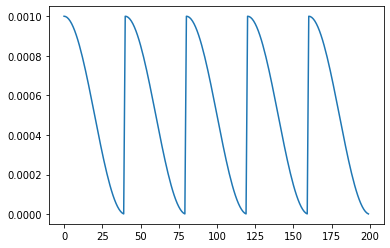

In [44]:
lrs = []
lr = 0.001
for i in range(200):
    lrs.append(cosine_lr(lr, i, 40) + 1e-7)
plt.plot(lrs)

In [69]:
def cosine_lr(lr, epoch, step_size):
    lr = lr/2 * (cos(pi*(epoch%step_size)/step_size)+1)
    return lr

def train(lr, batch_size, epochs, low_lr, step_size, dropout, cycle_bool):
    lr = lr
    init_lr = lr
    batch_size = batch_size
    params = {
        'batch_size': batch_size,
        'shuffle': True,
        'num_workers': 0
    }
    epochs = epochs
#     step_size = trial.suggest_int("step_size",5,100)
    highest_acc = 0
#     dim = trial.suggest_categorical("layer_dims", [32,64,128,256,512])
#     print(type(dim))
    dropout = dropout
    net = Classifier(train_embeddings, dropout=dropout)
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    training_set = DataReader(X_train_stats, x_train_tokenized_sentences, y_train_df, target)
    train_loader = DataLoader(training_set, **params)
    validation_set = DataReader(X_val_stats, x_val_tokenized_sentences, y_val_df, target)
    val_loader = DataLoader(validation_set, **params)

    net = net.to(device)
    criterion = criterion.to(device)
    liveloss = PlotLosses()
    
    low_lr = low_lr
#     cyclic_bool = trial.suggest_categorical("cyclic_bool",[True, False])
    plateau = 0
    for epoch in range(epochs):
        logs = {}
        if cycle_bool:
            for a in optimizer.param_groups:
                lr = cosine_lr(init_lr, epoch, step_size) + low_lr
                a['lr'] = lr

        t_loss, a, acc = 0, 0, 0
        for x_sparse, x_text, y_train in train_loader:
            a+=1

            x_sparse, x_text, y_train = x_sparse.to(device, dtype = torch.int64), x_text.to(device, dtype = torch.int64), y_train.to(device)
            optimizer.zero_grad()
            net.train()
            y_pred = net(x_sparse, x_text)
            train_loss = F.cross_entropy(y_pred,y_train)
            t_loss += train_loss
            train_loss.backward()
            optimizer.step()
            acc += (y_pred.argmax(dim=1) == y_train).sum().float() / float(y_train.size(0))

        print(acc/a)
        t_loss /= a
        if epoch%2 == 0:
            logs['CE Loss'] = t_loss / a
            logs['Accuracy'] = acc/a
            with torch.set_grad_enabled(False):
                test_loss, a, acc = 0, 0, 0
                for x_sparse_val, x_text_val, y_val in val_loader:
                    a += 1
                    x_sparse_val, x_text_val, y_val = x_sparse_val.to(device, dtype = torch.int64), x_text_val.to(device, dtype = torch.int64), y_val.to(device)
                    y_test_pred = net(x_sparse_val, x_text_val)
                    y_test_pred = torch.squeeze(y_test_pred)
                    test_loss += F.cross_entropy(y_test_pred,y_val)
                    acc += (y_test_pred.argmax(dim=1) == y_val).sum().float() / float(y_val.size(0))
            if (acc/a)>highest_acc: 
                plateau = 0
                highest_acc = acc/a
                torch.save(net.state_dict(),"./model_info/5_June_2.pth")
            else:
                plateau += 1
            print(acc/a)
            test_loss /= a

            logs['Val CE Loss'] = test_loss / a
            logs['Val Accuracy'] = acc/a
            logs['Highest Acc'] = highest_acc
            print(f'[epoch]: {epoch}, [Train Loss]: {t_loss.item()}, [Val Loss]: {test_loss.item()}')
#             if plateau>=10:
#                 for a in optimizer.param_groups:
#                     a['lr'] = lr/2
            if plateau>=40:
                break
        liveloss.update(logs)
        liveloss.send()
    return highest_acc, net

In [74]:
lr = 0.0003
batch_size = 128
epochs = 400
low_lr = 1e-8
step_size = 10
dropout = 0.4
cycle_bool = True
acc, net = train(lr, batch_size, epochs, low_lr, step_size, dropout, cycle_bool)

KeyboardInterrupt: 

# Testing

In [75]:
from sklearn.metrics import roc_auc_score, classification_report, precision_score, recall_score, f1_score
import sklearn
from collections import OrderedDict

In [88]:
frame = pd.read_csv('./adv_test.csv', index_col=False)
target = "Rating"
frame['Rating'].value_counts()
frame = preprocess_sparse(frame)

age = Discretize().fit_transform(frame[['Age']]).drop(['Age'],axis=1)
frame1 = frame.loc[:,'Rating':'unfav']
frame_sparse = frame1.loc[:,'Rating':'Mostwatchedtvprogrammes_Weather']
frame_sparse = pd.concat((frame_sparse,age), axis=1)

frame_x_text = frame1.loc[:,'fav':'unfav']

x_train_text = []
for i in frame_x_text['fav']+frame_x_text['unfav']:
    text = tokenizer(i)
    x_train_text.append(text)
    
x_train_tokenized_sentences = np.array([[word_to_id[i] for i in j] for j in x_train_text])

# # Pad tokens with 0s
for i in range(len(x_train_tokenized_sentences)):
    a = x_train_tokenized_sentences[i]
    x_train_tokenized_sentences[i] = np.concatenate([a,np.zeros(max_len-len(a))])

X_test_stats = frame_sparse.loc[:,'Gender_F':'Age_80_100']
X_test_stats.to_csv('./processed_splits/X_test_stats.csv', index=False)
X_test_text = frame_x_text
X_test_text.to_csv('./processed_splits/X_test_text.csv', index=False)
y_text_df  = pd.DataFrame(frame_sparse[target], columns=[target])
y_text_df[target].values[y_text_df[target].values>1]=2
y_text_df -= 1
y_text_df.to_csv('./processed_splits/y_text_df.csv', index=False)

Bad Frames: 0


In [89]:
net = Classifier(train_embeddings, dropout=dropout).to(device)
net.load_state_dict(torch.load("./model_info/5_June_2.pth"))

params = {
        'batch_size': 1,
        'shuffle': False,
        'num_workers': 0
    }
testing_set = DataReader(X_test_stats, x_train_tokenized_sentences, y_text_df, target)
test_loader = DataLoader(testing_set, **params)

predictions = {}
acc, a = 0, 0
for x_sparse, x_text, y_test in test_loader:
    with torch.set_grad_enabled(False):
        a += 1
#         net.eval()
        x_sparse, x_text, y_test = x_sparse.to(device, dtype = torch.int64), x_text.to(device, dtype = torch.int64), y_test.to(device)
        y_pred = net(x_sparse,x_text)
        acc += (y_pred.argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
        predictions[a] = [*x_sparse.cpu().numpy(), y_pred.argmax(dim=1).item(),y_test.item()]
acc /= a
print("Testing Accuracy: ", acc)

Testing Accuracy:  tensor(0.7259, device='cuda:0')


In [90]:
rows = []
for i in predictions:
    rows.append([*list(predictions[i][0]),predictions[i][1],predictions[i][2]])
result = pd.DataFrame(rows, columns=[*X_test_stats.columns,'y_pred','y_test'])

In [91]:
result

,Gender_F,Gender_M,Homecountry_Canada,Homecountry_CzechRepublic,Homecountry_GreatBritain,Homecountry_India,Homecountry_Italy,Homecountry_Phillipines,Homecountry_Romania,Homecountry_SaudiArabia,...,Mostwatchedtvprogrammes_ReligionampEthics,Mostwatchedtvprogrammes_Sport,Mostwatchedtvprogrammes_Weather,Age_0_20,Age_20_40,Age_40_60,Age_60_80,Age_80_100,y_pred,y_test
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
4,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,0,1,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,1
7,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [92]:
g = []
for i,j in zip(result['Gender_F'], result['Gender_M']):
    if i==1: g.append('F')
    else: g.append('M')
gender = pd.DataFrame(g,columns=["Gender"])
a = []
for i,j,k,l,m in zip(result['Age_0_20'], result['Age_20_40'], result['Age_40_60'], result['Age_60_80'], result['Age_80_100']):
    if i==1: a.append(0)
    elif j==1: a.append(1)
    elif k==1: a.append(2)
    elif l==1: a.append(3)
    else: a.append(4)
age = pd.DataFrame(a,columns=["Age"])
a = []
for i,j,k,l in zip(result['Income_0'], result['Income_1'], result['Income_2'], result['Income_3']):
    if i==1: a.append(0)
    elif j==1: a.append(1)
    elif k==1: a.append(2)
    elif l==1: a.append(3)
income = pd.DataFrame(a,columns=["Income"])

In [93]:
hc = result[result.columns[result.columns.to_series().str.contains('Homecountry')]]

In [94]:
countries = []
for i in range(hc.shape[0]):
    tmp = hc.loc[i]
    l = np.where(tmp.values==1)[0][0]
    countries.append(hc.columns[l].split('_')[-1])
Homecountry = pd.DataFrame(countries, columns=['Homecountry'])

In [95]:
adid = frame['AdId']

In [96]:
result_metrics = pd.concat([adid,gender,age,income,Homecountry,result.loc[:,'y_pred':'y_test']], axis=1)

In [97]:
result_metrics

,AdId,Gender,Age,Income,Homecountry,y_pred,y_test
0,A18_07,F,2,2,Canada,0,0
1,A12_15,M,0,2,UnitedKingdom,1,1
2,A17_01,M,0,2,UnitedKingdom,1,1
3,A10_01,M,1,1,UnitedKingdom,1,1
4,A10_06,M,1,2,UnitedStatesofAmerica,0,1
5,A14_06,F,0,1,UnitedStatesofAmerica,0,0
6,A06_06,M,0,3,Canada,1,1
7,A20_01,F,0,0,Canada,0,0
8,A12_05,M,1,2,Canada,0,0
9,A05_09,M,0,2,UnitedStatesofAmerica,0,0


In [98]:
def metrics_from_df(df:pd.DataFrame, confidence_threshold=0):
    """Drop examples with probability < confidence_threshold from calc"""
    y_true = df['y_pred']
    y_pred = df['y_test']
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    return {
        "TPR": TPR, "TNR": TNR, "PPV": PPV, "NPV": NPV, "FPR": FPR, "FNR": FNR, "FDR": FDR, "ACC": ACC
    }

class GroupFairnessMetrics:
    def __init__(self, model_inference_data:pd.DataFrame, protected_feature:str):
        """
        Compute fairness metrics between 2 groups of population - privileged & unprivileged
        Based on your dataset you could use,
            "Female" to privileged_grp_label and 
            "Male" to be unprivileged_grp_label
        for Gender as the protected_feature
        All metrics are computed on model_inference_data which has RATING and PREDICTED_RATING values for each row
        """
        self._df, self._pf, = model_inference_data, protected_feature
        self._base_metrics = "fairness_metrics_per_class"
        self._pf_metrics_df = self._df.groupby(self._pf).apply(metrics_from_df).to_frame(self._base_metrics)
    
    def fetch_base_metrics(self):
        return self._pf_metrics_df
    
    def equal_opportunity_difference(self, pg_lbl:str, upg_lbl:str, rating_class=1):
        r"""TPR{unprivileged} - TPR{privileged} ideally should be zero"""
        upg_opp = self._pf_metrics_df.loc[upg_lbl][self._base_metrics]["TPR"][rating_class]
        pg_opp = self._pf_metrics_df.loc[pg_lbl][self._base_metrics]["TPR"][rating_class]
        return upg_opp - pg_opp

    def average_odds_difference(self, pg_lbl:str, upg_lbl:str, rating_class=1):
        """Average of difference in FPR and TPR for unprivileged and privileged groups"""
        tpr_diff = self.equal_opportunity_difference(pg_lbl, upg_lbl, rating_class)
        
        upg_fpr = self._pf_metrics_df.loc[upg_lbl][self._base_metrics]["FPR"][rating_class]
        pg_fpr = self._pf_metrics_df.loc[pg_lbl][self._base_metrics]["FPR"][rating_class]
        fpr_diff = upg_fpr - pg_fpr
        
        return 0.5 * (fpr_diff + tpr_diff)
    
def plot_for_metric_class(metric_df:pd.DataFrame, metric:str="FPR", rating_class:int=1):
    """Generates plot for metric and given rating_class from metric_df indexed by dimension of interest"""
    plot_df = metric_df.apply(lambda m: m["fairness_metrics_per_class"][metric][rating_class], axis=1)
    plot_df = plot_df.reset_index().rename({0: metric}, axis=1)
    return plot_df

## Gender Bias

In [99]:
gender_fairness_metrics = GroupFairnessMetrics(result_metrics, 'Gender')

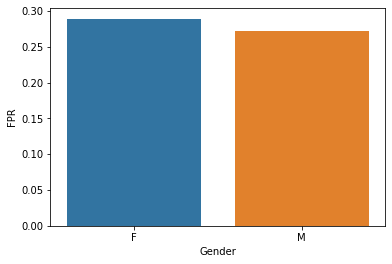

In [100]:
plot_df = plot_for_metric_class(gender_fairness_metrics.fetch_base_metrics())
ax = sns.barplot(x='Gender', y="FPR", data=plot_df)

## Age Bias

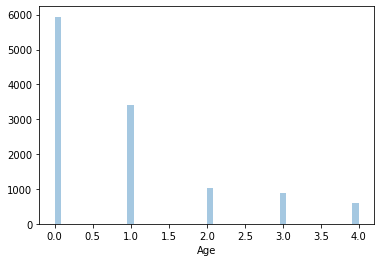

In [101]:
ax = sns.distplot(result_metrics['Age'], kde=False)

In [102]:
result_metrics['Age'].value_counts()

0    5941
1    3403
2    1030
3     897
4     609
Name: Age, dtype: int64

                            fairness_metrics_per_class
Age                                                   
0    {'TPR': [0.6910812157448929, 0.716139076284379...
1    {'TPR': [0.7757894736842105, 0.807052561543579...
2    {'TPR': [0.7209302325581395, 0.7734375], 'TNR'...
3    {'TPR': [0.7229601518026565, 0.635135135135135...
4    {'TPR': [0.682, 0.6422018348623854], 'TNR': [0...


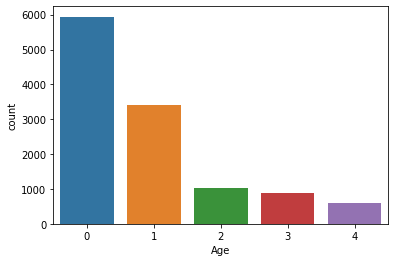

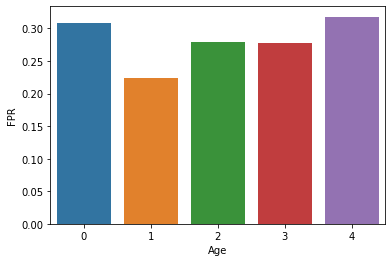

In [103]:
ax = sns.countplot(result_metrics['Age'])
age_metrics_df = result_metrics.groupby('Age').apply(metrics_from_df).to_frame('fairness_metrics_per_class')
print(age_metrics_df)
plt.show()
ax = sns.barplot(x='Age',y='FPR', data=plot_for_metric_class(age_metrics_df))

In [104]:
age_gfm = GroupFairnessMetrics(result_metrics, 'Age')
print("Equal Opportunity Difference")
print(age_gfm.equal_opportunity_difference(1, 2), age_gfm.equal_opportunity_difference(0, 4))

print("Average Odds Difference")
print(age_gfm.average_odds_difference(0,4), age_gfm.average_odds_difference(1,2))

Equal Opportunity Difference
-0.033615061543579516 -0.07393724142199454
Average Odds Difference
-0.03242801283855082 0.010622089791245737


## Income Bias

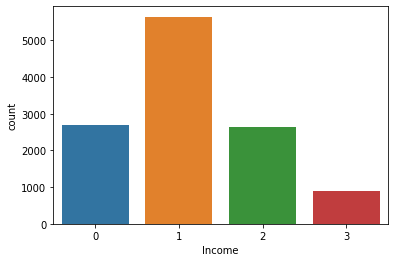

In [105]:
ax = sns.countplot(result_metrics['Income'])

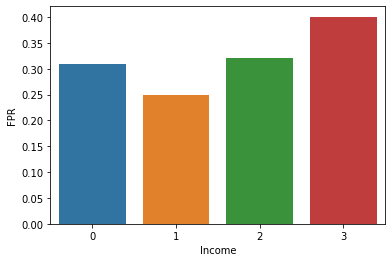

In [106]:
income_metrics_df = result_metrics.groupby('Income').apply(metrics_from_df).to_frame("fairness_metrics_per_class")
plot_df = plot_for_metric_class(income_metrics_df)
ax = sns.barplot(x='Income', y="FPR", data=plot_df)

In [107]:
income_gfm = GroupFairnessMetrics(result_metrics,'Income')
print(f"{income_gfm.equal_opportunity_difference(0, 1)}\t{income_gfm.equal_opportunity_difference(0, 3)}")
print(f"{income_gfm.average_odds_difference(0, 1)}\t{income_gfm.average_odds_difference(0, 3)}")

-0.0007791742016306502	-0.031986882351086265
-0.029981393024223396	0.030118154925140694


## Homecountry Bias

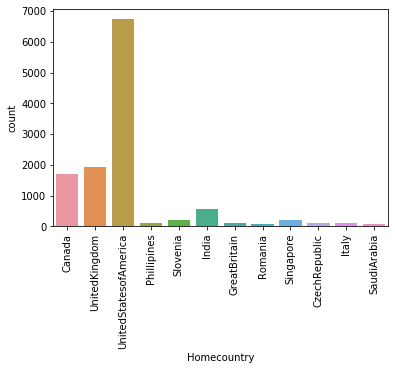

In [108]:
ax = sns.countplot(result_metrics['Homecountry'])
_=ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

/home/user/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/user/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/user/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/user/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


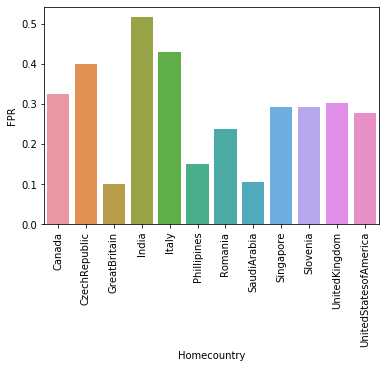

In [109]:
homecountry_metrics_df = result_metrics.groupby('Homecountry').apply(metrics_from_df).to_frame("fairness_metrics_per_class")
plot_df = plot_for_metric_class(homecountry_metrics_df)
ax = sns.barplot(x='Homecountry', y="FPR", data=plot_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

# Kitchen and Home Ads

GENDER


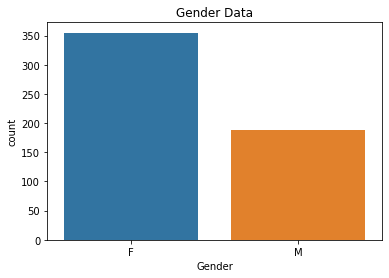

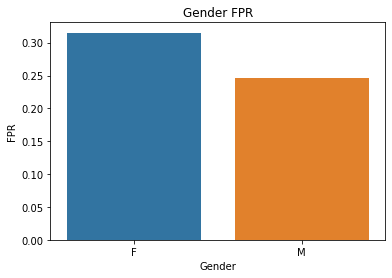

Gender EOD:  0.08034188034188039
Gender AOD:  0.005414932504715808
INCOME


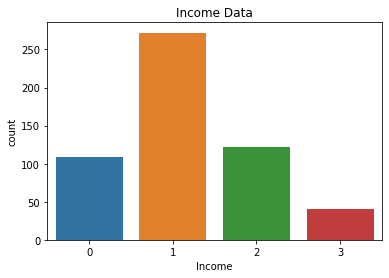

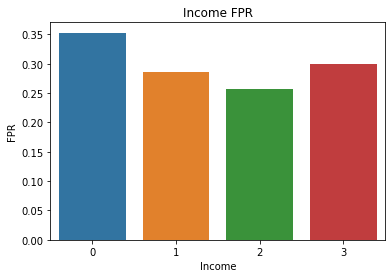

Income EOD: -0.0007791742016306502	-0.031986882351086265
Income AOD: -0.029981393024223396	0.030118154925140694


In [110]:
kitchen_results = result_metrics[result_metrics['AdId'].str.startswith("A11_")]
print("GENDER")
ax = sns.countplot(kitchen_results['Gender']).set_title("Gender Data")
plt.show()
gender_metrics_df = kitchen_results.groupby('Gender').apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x='Gender', y="FPR", data=plot_for_metric_class(gender_metrics_df)).set_title("Gender FPR")
plt.show()
gender_fairness_metrics = GroupFairnessMetrics(kitchen_results, 'Gender')
print("Gender EOD: ",gender_fairness_metrics.equal_opportunity_difference("F", "M"))
print("Gender AOD: ",gender_fairness_metrics.average_odds_difference("F", "M"))

print("INCOME")
INCOME = "Income"
ax = sns.countplot(kitchen_results[INCOME]).set_title("Income Data")
plt.show()
income_metrics_df = kitchen_results.groupby(INCOME).apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x=INCOME, y="FPR", data=plot_for_metric_class(income_metrics_df)).set_title("Income FPR")
plt.show()
income_gfm = GroupFairnessMetrics(result_metrics,'Income')
print(f"Income EOD: {income_gfm.equal_opportunity_difference(0, 1)}\t{income_gfm.equal_opportunity_difference(0, 3)}")
print(f"Income AOD: {income_gfm.average_odds_difference(0, 1)}\t{income_gfm.average_odds_difference(0, 3)}")


# Baby Products

GENDER


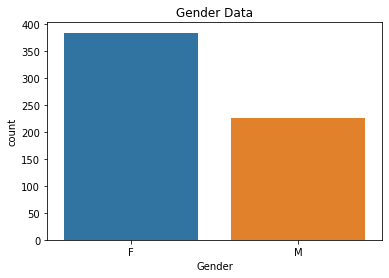

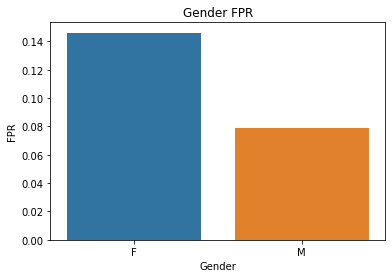

Gender EOD:  0.08034188034188039
Gender AOD:  0.005414932504715808
INCOME


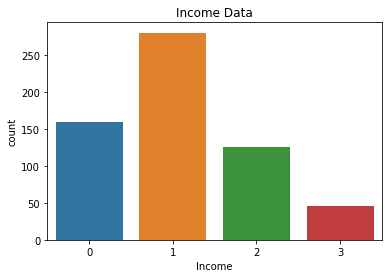

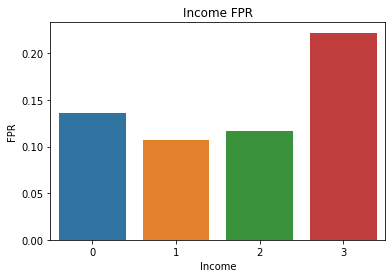

Income EOD: -0.0007791742016306502	-0.031986882351086265
Income AOD: -0.029981393024223396	0.030118154925140694


In [111]:
baby_results = result_metrics[result_metrics['AdId'].str.startswith("A03_")]
print("GENDER")
ax = sns.countplot(baby_results['Gender']).set_title("Gender Data")
plt.show()
gender_metrics_df = baby_results.groupby('Gender').apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x='Gender', y="FPR", data=plot_for_metric_class(gender_metrics_df)).set_title("Gender FPR")
plt.show()
gender_fairness_metrics = GroupFairnessMetrics(baby_results, 'Gender')
print("Gender EOD: ",gender_fairness_metrics.equal_opportunity_difference("F", "M"))
print("Gender AOD: ",gender_fairness_metrics.average_odds_difference("F", "M"))

print("INCOME")
INCOME = "Income"
ax = sns.countplot(baby_results[INCOME]).set_title("Income Data")
plt.show()
income_metrics_df = baby_results.groupby(INCOME).apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x=INCOME, y="FPR", data=plot_for_metric_class(income_metrics_df)).set_title("Income FPR")
plt.show()
print(f"Income EOD: {income_gfm.equal_opportunity_difference(0, 1)}\t{income_gfm.equal_opportunity_difference(0, 3)}")
print(f"Income AOD: {income_gfm.average_odds_difference(0, 1)}\t{income_gfm.average_odds_difference(0, 3)}")


# Consumer Electronics

GENDER


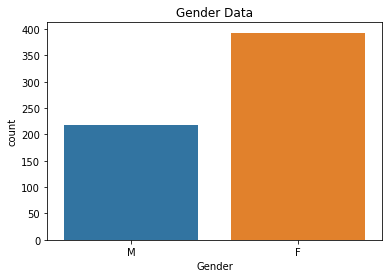

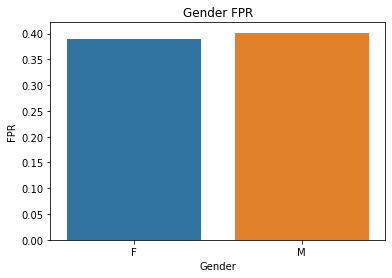

Gender EOD:  0.08034188034188039
Gender AOD:  0.005414932504715808
AGE


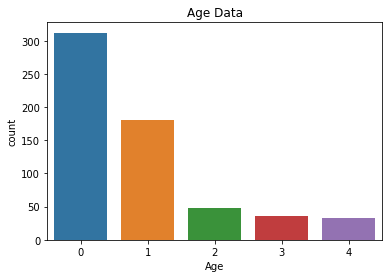

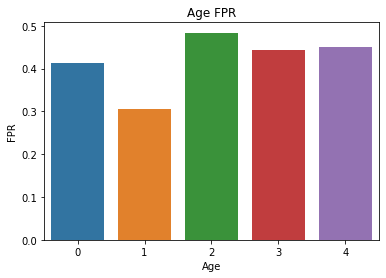

Age EOD: 0.007325888211684228	-0.031207708149455615
Age AOD: 0.009605327595315072	0.06009954794936409
INCOME


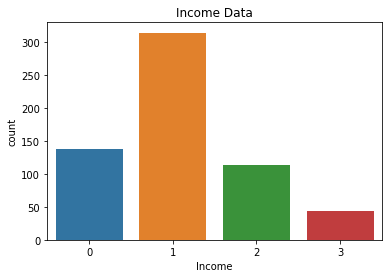

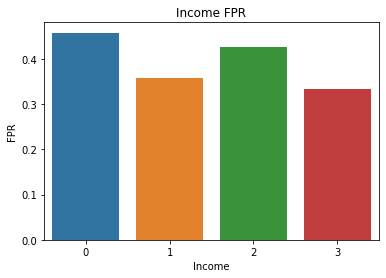

Income EOD: -0.0007791742016306502	-0.031986882351086265
Income AOD: -0.029981393024223396	0.030118154925140694


In [112]:
electronics_results = result_metrics[result_metrics['AdId'].str.startswith("A06_")]
print("GENDER")
ax = sns.countplot(electronics_results['Gender']).set_title("Gender Data")
plt.show()
gender_metrics_df = electronics_results.groupby('Gender').apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x='Gender', y="FPR", data=plot_for_metric_class(gender_metrics_df)).set_title("Gender FPR")
plt.show()
gender_fairness_metrics = GroupFairnessMetrics(kitchen_results, 'Gender')
print("Gender EOD: ",gender_fairness_metrics.equal_opportunity_difference("F", "M"))
print("Gender AOD: ",gender_fairness_metrics.average_odds_difference("F", "M"))

print("AGE")
AGE = "Age"
ax = sns.countplot(electronics_results[AGE]).set_title("Age Data")
plt.show()
income_metrics_df = electronics_results.groupby(AGE).apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x=AGE, y="FPR", data=plot_for_metric_class(income_metrics_df)).set_title("Age FPR")
plt.show()
print(f"Age EOD: {income_gfm.equal_opportunity_difference(0, 2)}\t{income_gfm.equal_opportunity_difference(1, 3)}")
print(f"Age AOD: {income_gfm.average_odds_difference(0, 2)}\t{income_gfm.average_odds_difference(1, 3)}")


print("INCOME")
INCOME = "Income"
ax = sns.countplot(electronics_results[INCOME]).set_title("Income Data")
plt.show()
income_metrics_df = electronics_results.groupby(INCOME).apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x=INCOME, y="FPR", data=plot_for_metric_class(income_metrics_df)).set_title("Income FPR")
plt.show()
print(f"Income EOD: {income_gfm.equal_opportunity_difference(0, 1)}\t{income_gfm.equal_opportunity_difference(0, 3)}")
print(f"Income AOD: {income_gfm.average_odds_difference(0, 1)}\t{income_gfm.average_odds_difference(0, 3)}")


# Sports And Outdoors

GENDER


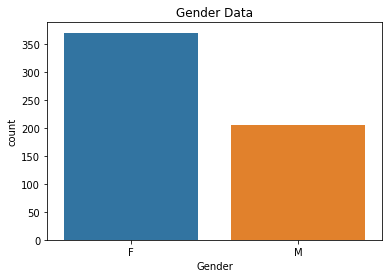

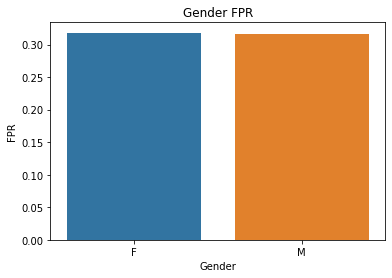

Gender EOD:  0.08034188034188039
Gender AOD:  0.005414932504715808
AGE


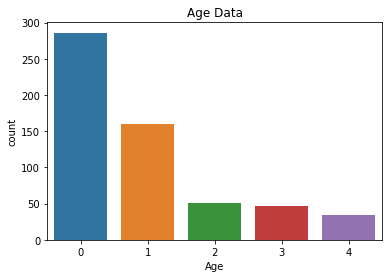

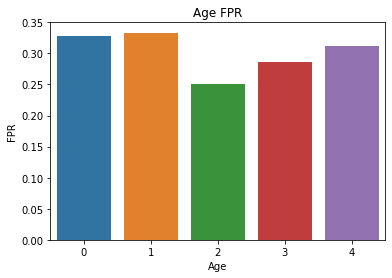

Age EOD: 0.007325888211684228	-0.031207708149455615
Age AOD: 0.009605327595315072	0.06009954794936409
INCOME


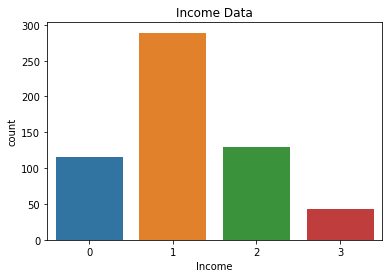

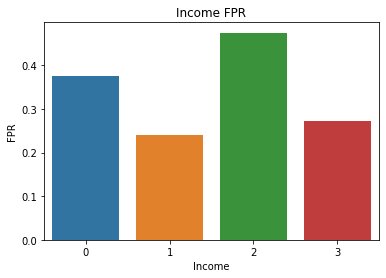

Income EOD: -0.0007791742016306502	-0.031986882351086265
Income AOD: -0.029981393024223396	0.030118154925140694


In [113]:
electronics_results = result_metrics[result_metrics['AdId'].str.startswith("A18_")]
print("GENDER")
ax = sns.countplot(electronics_results['Gender']).set_title("Gender Data")
plt.show()
gender_metrics_df = electronics_results.groupby('Gender').apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x='Gender', y="FPR", data=plot_for_metric_class(gender_metrics_df)).set_title("Gender FPR")
plt.show()
gender_fairness_metrics = GroupFairnessMetrics(kitchen_results, 'Gender')
print("Gender EOD: ",gender_fairness_metrics.equal_opportunity_difference("F", "M"))
print("Gender AOD: ",gender_fairness_metrics.average_odds_difference("F", "M"))

print("AGE")
AGE = "Age"
ax = sns.countplot(electronics_results[AGE]).set_title("Age Data")
plt.show()
income_metrics_df = electronics_results.groupby(AGE).apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x=AGE, y="FPR", data=plot_for_metric_class(income_metrics_df)).set_title("Age FPR")
plt.show()
print(f"Age EOD: {income_gfm.equal_opportunity_difference(0, 2)}\t{income_gfm.equal_opportunity_difference(1, 3)}")
print(f"Age AOD: {income_gfm.average_odds_difference(0, 2)}\t{income_gfm.average_odds_difference(1, 3)}")


print("INCOME")
INCOME = "Income"
ax = sns.countplot(electronics_results[INCOME]).set_title("Income Data")
plt.show()
income_metrics_df = electronics_results.groupby(INCOME).apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x=INCOME, y="FPR", data=plot_for_metric_class(income_metrics_df)).set_title("Income FPR")
plt.show()
print(f"Income EOD: {income_gfm.equal_opportunity_difference(0, 1)}\t{income_gfm.equal_opportunity_difference(0, 3)}")
print(f"Income AOD: {income_gfm.average_odds_difference(0, 1)}\t{income_gfm.average_odds_difference(0, 3)}")


In [ ]:
# file_path = './imp_sparse_features_train.csv'
# target = 'Rating'
# split = 0.3
# x_train, x_val, y_train, y_val, tgt_type = read_preprocess.read_and_preprocess(file_path, target, split)
x_train = torch.from_numpy(x_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).long())

x_val = torch.from_numpy(x_val.to_numpy()).float()
y_val = torch.squeeze(torch.from_numpy(y_val.to_numpy()).long())

In [ ]:
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,40,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [ ]:
pca_transformer = PCA(n_components=35)
pca = pca_transformer.fit_transform(X_std)

In [ ]:
def train(lr, batch_size, epochs, x_train, y_train, x_val, y_val,step_size, tgt_type):
    print(y_train.shape[1])
    highest_acc = 0
    net = DNN(x_train.shape[1], tgt_type, [128,128,64,32],y_train.shape[1])
    
    if tgt_type=="regression":
        criterion = nn.MSELoss()
    else:
        criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    params = {
        'batch_size': 64,
        'shuffle': True,
        'num_workers': 0
    }
    training_set = dataset_csv(x_train, y_train)
    train_loader = DataLoader(training_set, **params)
    validation_set = dataset_csv(x_val, y_val)
    val_loader = DataLoader(validation_set, **params)
    
    
    net = net.to(device)
    criterion = criterion.to(device)
    
    for epoch in range(epochs):
        for a in optimizer.param_groups:
            lr = cosine_lr(lr, epoch, step_size) + 1e-5
            a['lr'] = lr
        t_loss, a, acc = 0, 0, 0
        log = {'y_train': [], 'y_val': [], 'y_pred': [], 'y_val_pred': []}
        for x_train, y_train in train_loader:
            a+=1
            x_train, y_train = x_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            net.train()
            y_pred = net(x_train)
            train_loss = criterion(y_pred, torch.max(y_train, 1)[1])
            t_loss += train_loss
            train_loss.backward()
            optimizer.step()
            acc += (y_pred.argmax(dim=1) == torch.max(y_train, 1)[1]).sum().float() / float(y_train.size(0))
        print(acc/a)
        t_loss /= a
        if epoch%1 == 0:
            with torch.set_grad_enabled(False):
                test_loss, a, acc = 0, 0, 0
                for x_val, y_val in val_loader:
                    a += 1
                    x_val, y_val = x_val.to(device),y_val.to(device)
                    y_test_pred = net(x_val)
                    y_test_pred = torch.squeeze(y_test_pred)
                    test_loss += criterion(y_test_pred, torch.max(y_val, 1)[1])
                    acc += (y_test_pred.argmax(dim=1) == torch.max(y_val, 1)[1]).sum().float() / float(y_val.size(0))
            if (acc/a)>highest_acc: 
                highest_acc = acc/a
                torch.save(net.state_dict(),"./model_info/14_may_1.pth")
            print(acc/a)
            test_loss /= a
            print(f'[epoch]: {epoch}, [Train Loss]: {t_loss.item()}, [Val Loss]: {test_loss.item()}')
        
        if tgt_type=="regression":
            if epoch%30==0:
                scaler_t = pickle.load(open('./model_info/scaler_t.pkl','rb'))
                y_0 = scaler_t.inverse_transform(log['y_train'])
                y_1 = scaler_t.inverse_transform(log['y_pred'])
                rmse = np.sqrt(mean_squared_error(y_0,y_1))
                print(rmse)
                y_0 = scaler_t.inverse_transform(log['y_val'])
                y_1 = scaler_t.inverse_transform(log['y_val_pred'])
                rmse = np.sqrt(mean_squared_error(y_0,y_1))
                print(rmse)
    return net, log

In [ ]:
trained_model, log = train(0.003, 512, 100, x_train, y_train, x_val, y_val, 10, tgt_type)

In [ ]:
# file_path = './upvotes/train.csv'
# target = 'Upvotes'

# X,y = read_and_preprocess_test(file_path, target, tgt_type)
ckpt_dir = "./model_info/14_may_1.pth"
def test(X,y, tgt_type, ckpt_dir):
    trained_model = DNN(x_train.shape[1], tgt_type, [128,128,64,32],y_train.shape[1])
    trained_model.load_state_dict(torch.load(ckpt_dir))
    trained_model
    x_test = X
    if y is not None:
        y_test = y
    trained_model.eval()
    y_pred = trained_model(x_test)
    y_pred = torch.squeeze(y_pred)
    return y_pred

In [ ]:
predictions = test(x_val,y_val,tgt_type,ckpt_dir)
enc = pickle.load(open('./model_info/OHE.pkl','rb'))
df = pd.DataFrame(columns=['gt','predictions'])
# df[['predictions']] = scaler_t.inverse_transform(df[['predictions']])

In [ ]:
gt = torch.max(y_val, 1)[1].detach().numpy()
df = pd.DataFrame(gt)
df

In [ ]:
df = pd.DataFrame(columns=['gt','predictions'])
df['gt'] = gt
df['predictions'] = predictions.argmax(dim=1)
pred_df = pd.DataFrame(classification_report(df['gt'], df['predictions'], output_dict=True))
pred_df

In [ ]:
cm = pd.DataFrame(confusion_matrix(df['gt'], df['predictions']))
cm

In [ ]:
file_path = './CICIDS2017/combined_data_test.csv'
target = 'Label'
x_test, y_test = read_preprocess.read_and_preprocess_test(file_path, target, split)

x_test = torch.from_numpy(x_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).long())

In [ ]:
predictions = test(x_test,y_test,tgt_type,ckpt_dir)
enc = pickle.load(open('./model_info/OHE.pkl','rb'))
df = pd.DataFrame(columns=['gt','predictions'])
gt = torch.max(y_test, 1)[1].detach().numpy()
df = pd.DataFrame(gt)
df = pd.DataFrame(columns=['gt','predictions'])
df['gt'] = gt
df['predictions'] = predictions.argmax(dim=1)
pred_df = pd.DataFrame(classification_report(df['gt'], df['predictions'], output_dict=True))
pred_df, pd.DataFrame(confusion_matrix(df['gt'], df['predictions']))

In [ ]:
pred.numpy()

In [ ]:
b = np.zeros((gt.size, gt.max()+1))
b[np.arange(gt.size),gt] = 1
gt2 = b

pred = predictions.argmax(dim=1).numpy()
b = np.zeros((pred.size,pred.max()+1))
b[np.arange(pred.size),pred] = 1
pred = b

In [ ]:
enc.inverse_transform(gt2)

In [ ]:
df['gt'] = enc.inverse_transform(gt2)
df['predictions'] = enc.inverse_transform(pred)
pred_df = pd.DataFrame(classification_report(df['gt'], df['predictions'], output_dict=True))
pred_df

In [ ]:
labels = df['gt'].unique().tolist()

In [ ]:
pd.DataFrame(confusion_matrix(df['gt'], df['predictions'],normalize = 'all'), index = labels,columns = labels)